# 18460 Project

In [1]:
%load_ext autoreload
%autoreload 2

from tasks import *
import numpy as np
from server import Server
import time

First, we initialize the task for a given configuration

In [2]:
#task = lrt.LinearRegressionTask(lrt.solo_config) # Linear regression
#task = ct.CircleTask() # Circle
task = lgrt.LogisticRegressionTask() # Logistic regression with mushrooms

Intializing task LogisticRegressionTask with config Config(clients=[<Computation.HIGH: 1>, <Computation.HIGH: 1>, <Computation.LOW: 2>, <Computation.LOW: 2>], lr=0.001, nlr=0.004)


Seeing the data

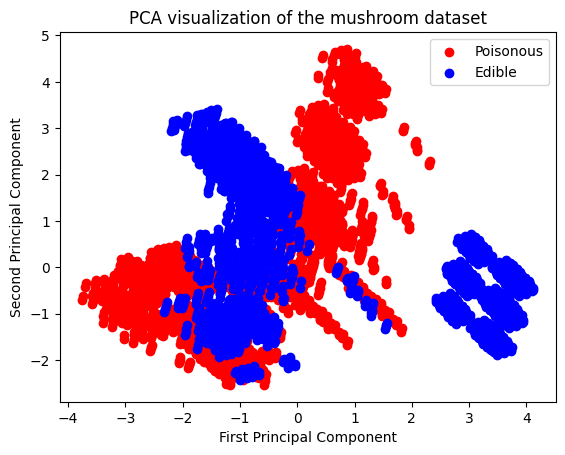

In [3]:
task.visualize()

Solve iteratively using federated learning

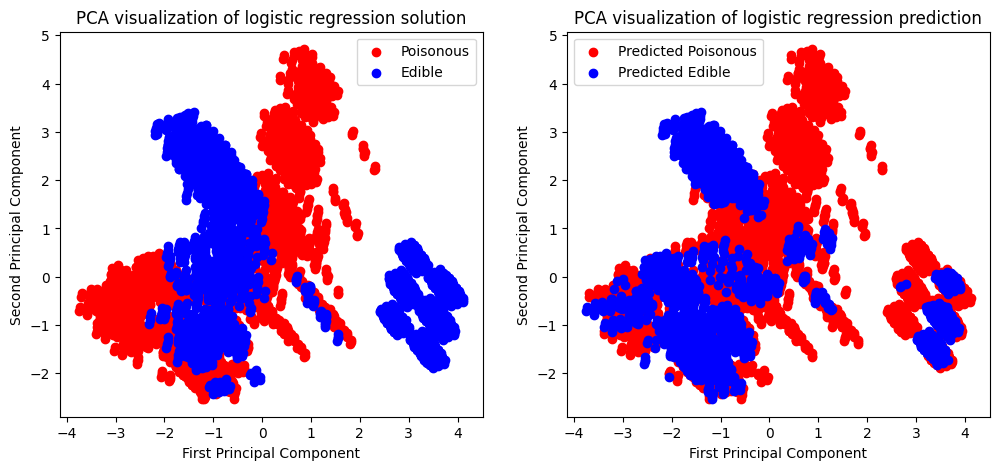


        Iteration 0: [-0.25459837 -0.8568039   2.05556656  0.61628222  1.03975288  0.36544154
 -1.54175868 -0.01935592 -1.29942309 -0.62105214 -0.31534498  1.09195567
 -0.32555552  0.87420811 -1.57997009  1.06449005 -0.33691431  0.07886105
 -0.04572191 -0.74180093  1.86588526 -0.1487301  -1.11420583]
        Cost: 10508.644685348909

        

        Iteration 500: [-0.12281318 -0.24416824  1.50058097  0.16701596  0.55666203  0.14901062
 -1.39232343  1.2909302  -0.84321979 -0.70834599 -0.5299821   0.60554105
 -0.49920993  0.4192208  -1.27073238  1.06449005 -0.17144142  0.4517496
 -0.32029241 -1.20608098  1.42630642 -0.10332944 -1.56015477]
        Cost: 5464.174782497325

        

        Iteration 1000: [-0.1418594  -0.09315258  1.31934812 -0.23014957  0.31168088  0.00324956
 -1.62262225  1.53430654 -0.91650345 -0.34952609 -0.69008781  0.03214892
 -0.59436595  0.40123511 -1.17520158  1.06449005  0.11322011  0.52720482
  0.25989142 -1.2126267   1.18432803  0.01649645 -1.31132445]
  

In [4]:
# Create server and initialize clients, before iteratively updating the consensus variables
server = Server(task)
server.connect_clients() # create clients with problem description including a partition of the dataset

start_time = time.perf_counter()
problem = task.get_problem()

k = 0
last_cost = float('infinity')

costs = []
while k < problem.max_iter and server.delta > problem.tol:
    consensus = server.consensus.flatten()
    
    if k == 0:
        task.visualize_solution(consensus)
    
    current_cost = problem.loss(consensus, task.dataset, problem.hyper_parameters)
    costs.append(current_cost)
    
    if k % 500 == 0:
        print(f'''
        Iteration {k}: {consensus}
        Cost: {current_cost}

        ''')
    
    # perform new iteration
    server.run_iteration(k+1)
    
    if np.linalg.norm(current_cost - last_cost) < problem.ctol:
        print(f"Condition reached: change in cost is {np.linalg.norm(current_cost - last_cost)} "
              f"which is smaller than {problem.ctol}")
        last_cost = current_cost
        break
        
    last_cost = current_cost
    
    k = k + 1
    
solution = server.consensus.flatten()
end_time = time.perf_counter()
if k >= problem.max_iter and server.delta > problem.tol:
    raise Exception("Did not converge")
    
if server.delta <= problem.tol:
    print(f"Condition reached: change in solution is {server.delta} "
          f"which is smaller than {problem.tol}")

print("")
print(f"Solution: {solution}")
print(f"Associated cost: {last_cost}")
print(f"Achieved in {k} iterations")
print(f"Elapsed time: {end_time - start_time}")

In [5]:
print(f"Condition reached: change in cost is 3.556177290420237e-07 "
      f"which is smaller than 1e-06")

print("")
print(f"Solution: [1.98329308 30.00047949]")
print(f"Associated cost: 88.03646964984635")
print(f"Achieved in 2303 iterations")
print(f"Elapsed time: 26.235602800006745")

Condition reached: change in cost is 3.556177290420237e-07 which is smaller than 1e-06

Solution: [1.98329308 30.00047949]
Associated cost: 88.03646964984635
Achieved in 2303 iterations
Elapsed time: 26.235602800006745


## Visualization of the solution

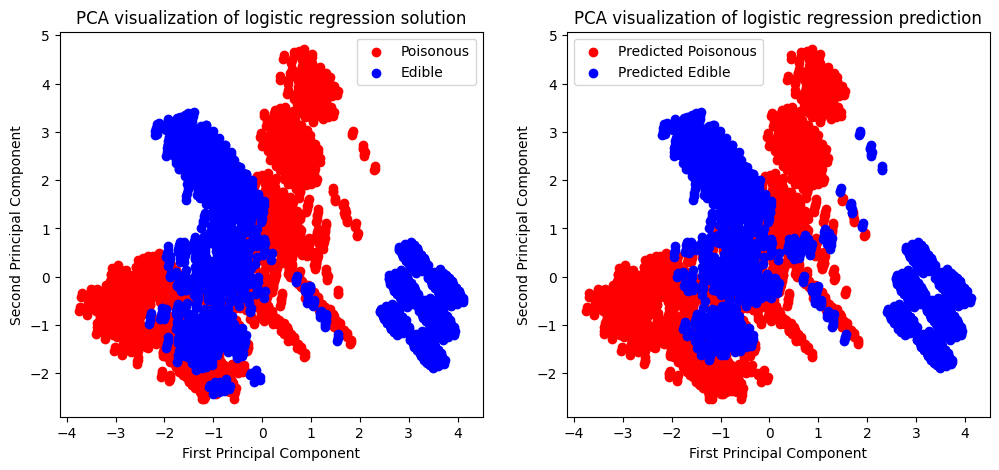

In [6]:
task.visualize_solution(solution)

Text(0.5, 1.0, 'Circle task result')

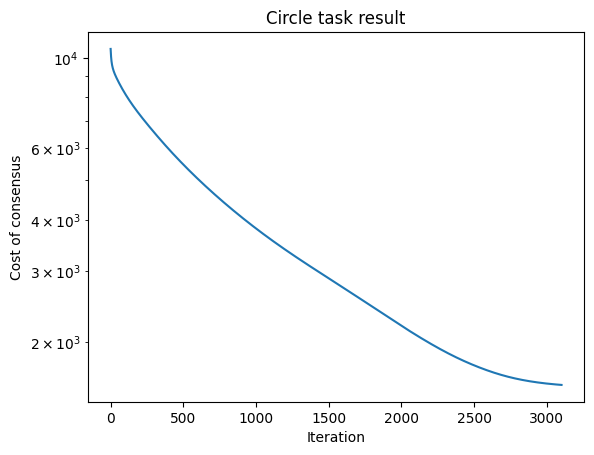

In [7]:
import matplotlib.pyplot as plt

plt.semilogy(costs)
plt.xlabel("Iteration")
plt.ylabel("Cost of consensus")

plt.title("Circle task result")